## Objective
Create spatial waveform plots and ms-scale raster plots to demonstrate Kilosort2 undermerging units.

In [217]:
# region Set up notebook imports
%load_ext autoreload
%autoreload 2
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from multiprocessing import Pool
import sys
from pathlib import Path
from tqdm import tqdm

from src import utils
from src.recording import Recording
from src.sorters.prop_signal import PropSignal
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup recording and sorters

In [31]:
RECORDING = Recording(utils.PATH_REC_DL.format("2953"), freq_min=300, freq_max=6000)
RMS = np.load("/data/MEAprojects/DLSpikeSorter/2953/prop_signal/thresh_5_full/rms.npy", allow_pickle=True)
##
rec_duration_ms = int(RECORDING.get_total_duration() * 1000)

In [32]:
PROP_SIGNAL = PropSignal("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2953/230101_133514_582221/log/windows_200_120/prop_signal", RECORDING)

In [36]:
KILOSORT = Kilosort(utils.PATH_SM4_DL.format("2953"), "first", RECORDING)

Getting spike times
Getting match counts and agreement scores


100%|██████████| 90/90 [00:00<00:00, 98.16it/s] 


Num Prop.: 90
Num Kilosort2: 167
Num single matches: 39

For Prop.:
Num max matches: 47
Num unique max matches: 34

For Kilosort2:
Num max matches: 46
Num unique max matches: 36


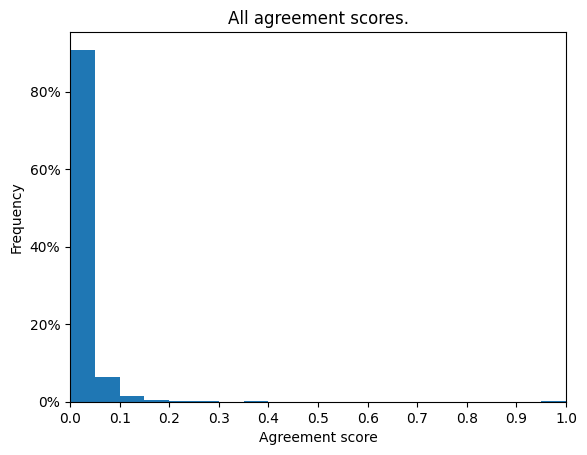

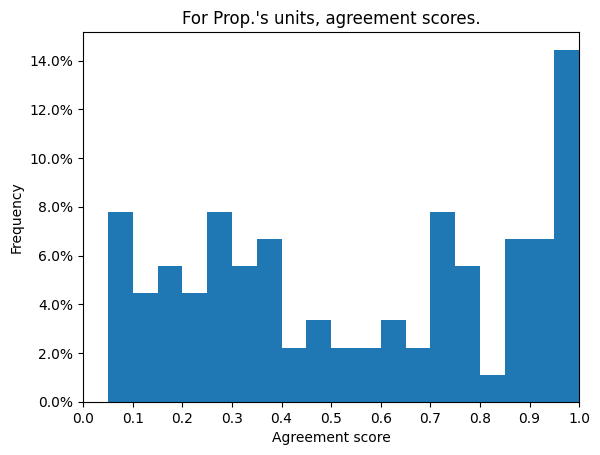

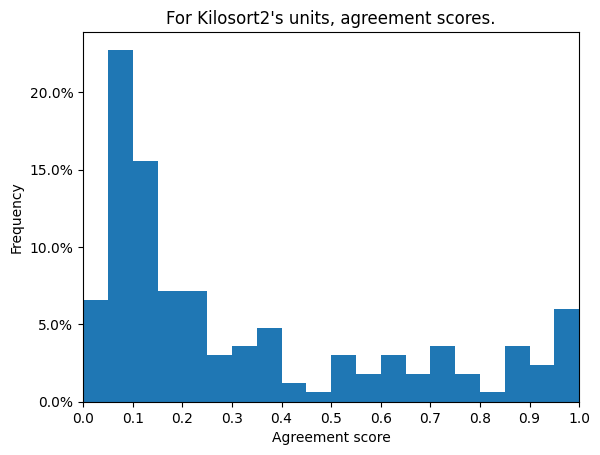

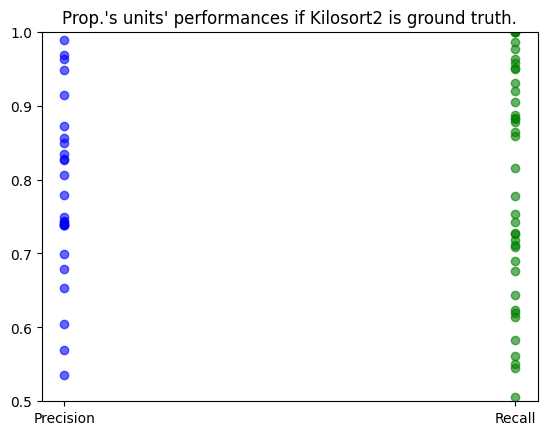

In [37]:
comparison = Comparison(PROP_SIGNAL, KILOSORT, score_formula=2)

## Setup plots

In [526]:
def bound_spike_times(st, start_ms, end_ms):
    st = np.array(st)
    return st[(start_ms <= st) & (st <= end_ms)]

In [347]:
def shorten_template(template, length):
    """
    Shorten template by taking window of center

    :param template:
        Shape (num_chans, num_samples)
    :param length:
        Desired new length of template

    :return:
        Shortened template
    """

    center = template.shape[1] // 2
    start = center-length//2
    return template[:, start:start+length]

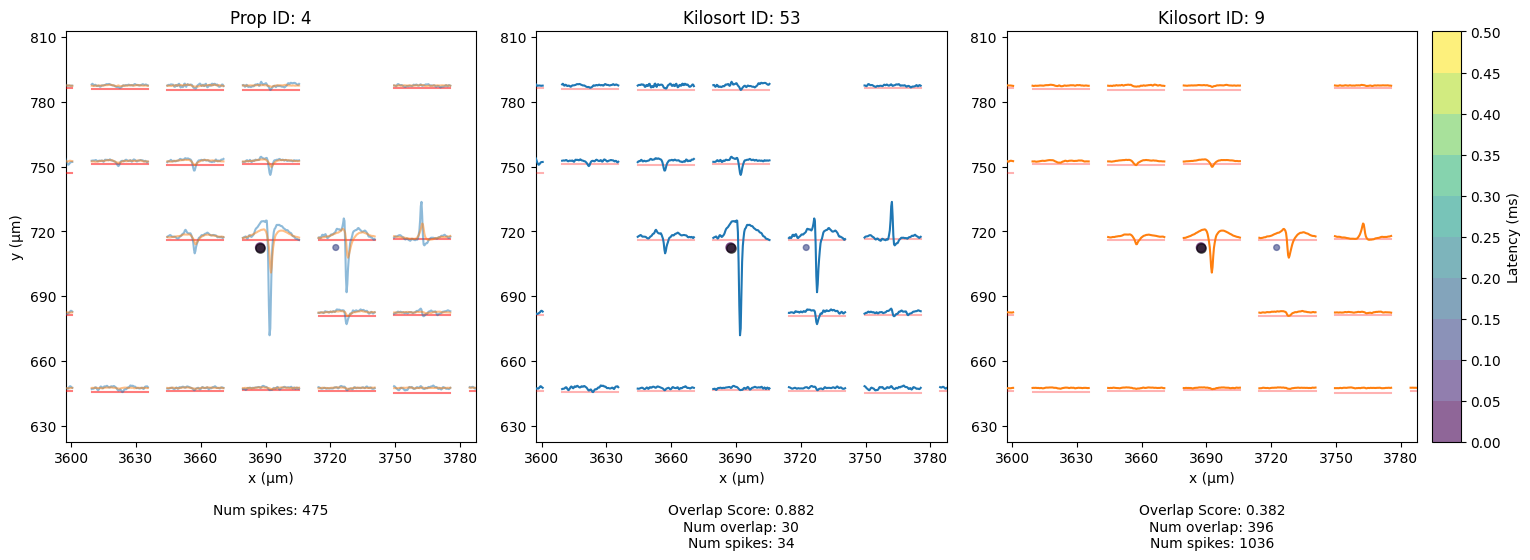

In [353]:
class UnderMerge:
    """
    Class to represent one or more kilosort units that match to the same prop unit
    """
    CMAP_KS_UNITS = plt.get_cmap("tab10")

    def __init__(self, prop_idx, match_thresh=0.5):
        ks_scores = comparison.agreement_scores[prop_idx, :]
        ks_ind = np.flatnonzero(ks_scores >= match_thresh)
        if ks_ind.size == 0:
            ks_ind = np.argsort(ks_scores)[-3:]

        ks_scores = ks_scores[ks_ind]
        ks_units = []
        amps = []
        for idx in ks_ind:
            unit = KILOSORT[idx]
            ks_units.append(unit)
            amps.append(np.min(unit.get_template_mean()))

        # Order kilosort units by descending average amplitude
        order = np.argsort(amps)

        self.ks_scores = ks_scores[order]
        self.ks_units = [ks_units[idx] for idx in order]
        self.ks_colors = [self.CMAP_KS_UNITS(i) for i in range(len(self))]
        self.prop = PROP_SIGNAL[prop_idx]

    def plot_footprints(self, save=False):
        WINDOW_HALF_SIZE = 1.20  # length and width of window will be WINDOW_HALF_SIZE * 2
        SCALE_H = 0.4 # Multiple height of waveform by this to scale it down
        WF_WIDTH = 13

        MAX_LATENCY = 10  # In frames
        CMAP_LATENCY = plt.get_cmap("viridis", MAX_LATENCY)  # tab20c

        MAX_DOT_SIZE = 45  # For marking which channels are in prop unit
        MARKERS = "oXDs*pP1267" # For distinguishing between props in a merge

        # Find which channels to plot
        locs = RECORDING.get_channel_locations()
        nearest_chan = RECORDING.nearest_chan

        chan_center = self.prop.chan
        loc_center = locs[chan_center]

        chans, dists = nearest_chan[chan_center]

        # Adjust WINDOW_HALF_SIZE if parts of propagation are outside of max_dist
        window_half_size = WINDOW_HALF_SIZE
        for df in self.prop.df:
            for elec in df.ID:
                dist = dists[chans == elec]
                if dist > window_half_size:
                    window_half_size = dist + 60

        max_dist = np.sqrt(2) * window_half_size  # Distance from center of window to corner
        scale_y = lambda y, loc: y * SCALE_H + loc[1]

        # 1 axis with all units + 1 axis for each unit
        num_axes = 1 + len(self.ks_units)
        figsize = 6*num_axes
        fig = plt.figure(figsize=(figsize, figsize/num_axes))
        grid = ImageGrid(fig, 111, # as in plt.subplot(111
                         nrows_ncols=(1, num_axes),
                         axes_pad=0.6,
                         cbar_location="right",
                         cbar_mode="single",
                         cbar_size="7%",
                         cbar_pad=0.15,
                         label_mode="all"
                         )

        # Setup axes
        xmin = loc_center[0] - window_half_size
        xmax = loc_center[0] + window_half_size

        ymin = loc_center[1] - window_half_size
        ymax = loc_center[1] + window_half_size

        grid[0].set_ylabel("y (μm)")

        for axis in grid:
            axis.set_aspect("equal")

            axis.set_xlim(xmin, xmax)
            axis.set_ylim(ymin, ymax)

            axis.xaxis.set_major_locator(plt.MaxNLocator(7))
            axis.yaxis.set_major_locator(plt.MaxNLocator(7))

            ## Mark which electrodes are in the prop signal

            for i, prop in enumerate(self.prop.df):
                locs_prop = locs[prop.ID] - 5
                locs_prop[:, 1] -= 10*i
                sizes = prop.small_window_cooccurrences.values
                sizes *= MAX_DOT_SIZE/np.max(sizes)
                scatter = axis.scatter(locs_prop[:, 0], locs_prop[:, 1],
                                       s=sizes, alpha=0.6, zorder=2, marker=MARKERS[i],
                                       c=prop.latency.values,cmap=CMAP_LATENCY, vmin=0, vmax=0.5)
                axis.scatter(*locs_prop[0, :], color="black", s=sizes[0], zorder=2, marker=MARKERS[i],
                             alpha=0.6)

        colorbar = axis.cax.colorbar(scatter, label="Latency (ms)")
        colorbar.set_ticks(np.arange(MAX_LATENCY+1)/RECORDING.get_sampling_frequency())

        for i in range(num_axes-1):
            ks_unit = self.ks_units[i]
            template = shorten_template(ks_unit.get_template_mean(), 81)
            for axis in (grid[0], grid[1+i]):
                # Plot channel templates for each kilosort unit

                for c in chans:
                    loc = locs[c]

                    # Check if channel is out of bounds
                    if np.sqrt(np.sum(np.square(loc - loc_center))) >= max_dist:
                        break

                    # Plot template
                    temp = template[c, :]
                    x_values = np.linspace(loc[0]-WF_WIDTH, loc[0]+WF_WIDTH, temp.size)

                    axis.plot(x_values, scale_y(temp, loc), c=self.ks_colors[i],
                              alpha=0.5+i*0.00 if axis == grid[0] else 1,
                              label=i if c == chans[0] else None,
                              zorder=10)

                    # Plot 5RMS
                    axis.plot(x_values, [scale_y(-RMS[c], loc)] * len(x_values), c="red", alpha=0.3, zorder=5)

            grid[1+i].set_title(f"Kilosort ID: {ks_unit.idx}")
            score = self.ks_scores[i]
            num_spikes = len(ks_unit)
            num_overlap = score * num_spikes

            grid[1+i].set_xlabel(
                        f"x (μm)\n\n"
                        f"Overlap Score: {score:.3f}\n"
                        f"Num overlap: {num_overlap:.0f}\n"
                        f"Num spikes: {num_spikes}",
                        linespacing=1.2
            )

        grid[0].set_title(f"Prop ID: {self.prop.id}")
        grid[0].set_xlabel(
            f"x (μm)\n\n"
            f"Num spikes: {len(self.prop)}",
            horizontalalignment='center',verticalalignment='top',
            fontweight="normal",
            linespacing=1.2
        )

        if not save:
            plt.show()
        else:
            fig.savefig(ROOT_PATH / f"{self.prop.id}.png", dpi=fig.dpi, bbox_inches='tight')
            plt.close(fig)

    def plot_raster_search(self, start_ms, end_ms,
                           window_duration=10, min_count=6,
                           search_ind=None):
        """
        Search for best rasters to plot and plot them

        :param search_ind:
            When searching for which windows to plot
            If None, search all kilosort units
            Else, search only search_ind units
        """

        kses = [bound_spike_times(kilosort_spike_times[ks_idx], start_ms, end_ms)
                for ks_idx in self.ks_ind]
        kses_cat = np.sort(np.concatenate(kses))

        if search_ind is None:
            kses_search = kses_cat
        else:
            kses_search = [bound_spike_times(kilosort_spike_times[ks_idx], start_ms, end_ms)
                          for ks_idx in self.ks_ind[search_ind]]
            kses_search = np.sort(np.concatenate(kses_search))

        idx = 0
        while idx < len(kses_search):
            start = kses_search[idx] - window_duration * 0.2
            left = np.searchsorted(kses_cat, start)
            right = np.searchsorted(kses_cat, start+window_duration, side="right")
            if right - left >= min_count:
                self.plot_raster(start, start+window_duration)
                assert search_ind is None, "idx=right not work for search_ind is None"
                idx = right
            else:
                idx += 1

        # kses = []
        # inds = []
        # for ks_idx in self.ks_ind[search_ind]:
        #     st = bound_spike_times(kilosort_spike_times[ks_idx], start_ms, end_ms)
        #     kses.append(st)
        #     inds.extend([ks_idx] * len(st))
        # kses_cat = np.concatenate(kses)
        # inds = np.asarray(inds)
        #
        # ind_sorted = np.argsort(kses_cat)
        # kses_cat = kses_cat[ind_sorted]
        # inds = inds[ind_sorted]
        #
        # idx = 0
        # while idx < len(kses):
        #     start = kses[idx] - window_duration * 0.2
        #     left = np.searchsorted(kses, start)
        #     right = np.searchsorted(kses, start+window_duration, side="right")
        #     if right - left >= min_count:
        #         self.plot_raster(start, start+window_duration)
        #     idx += 1


    def plot_raster(self, start_ms, end_ms):
        LINE_SIZE = 450

        fig, ax = plt.subplots(1, figsize=(6.5, 1.5), tight_layout=True)

        # Prop signal units' spike times
        prop = bound_spike_times(self.prop.spike_train, start_ms, end_ms)
        for st in prop:
            ax.scatter(st, 1, color="black", marker="|", s=LINE_SIZE, alpha=1)

        # Kilosort units' spike times
        kses = [bound_spike_times(kilosort_spike_times[ks_idx], start_ms, end_ms) for ks_idx in self.ks_ind]
        kses_cat = np.concatenate(kses)

        ks_unique, count = np.unique(kses_cat, return_counts=True)
        ks_overlap = set(ks_unique[count>1])  # Find if multiple ks units spike at same time

        for i in range(len(kses)):
            for st in kses[i]:
                y = -1
                if st in ks_overlap: y -= i*0.05
                ax.scatter(st, y, color=self.CMAP_KS_UNITS(i), marker="|", s=LINE_SIZE, alpha=1)

        ax.set_xlim(start_ms-0.01, end_ms+0.01)
        ax.set_xlabel("Time (ms)")
        ax.set_ylim(-2, 2)
        ax.set_yticks([])
        # ax.set_title(title)
        plt.show()

    def __len__(self):
        return len(self.ks_units)

##
prop_idx = 4
under_merge = UnderMerge(prop_idx, match_thresh=0.3) # 0.3
under_merge.plot_footprints(save=False)
#  under_merge.plot_raster_search(0, rec_duration_ms, window_duration=100, min_count=6, search_ind=None)

## Plot footprints

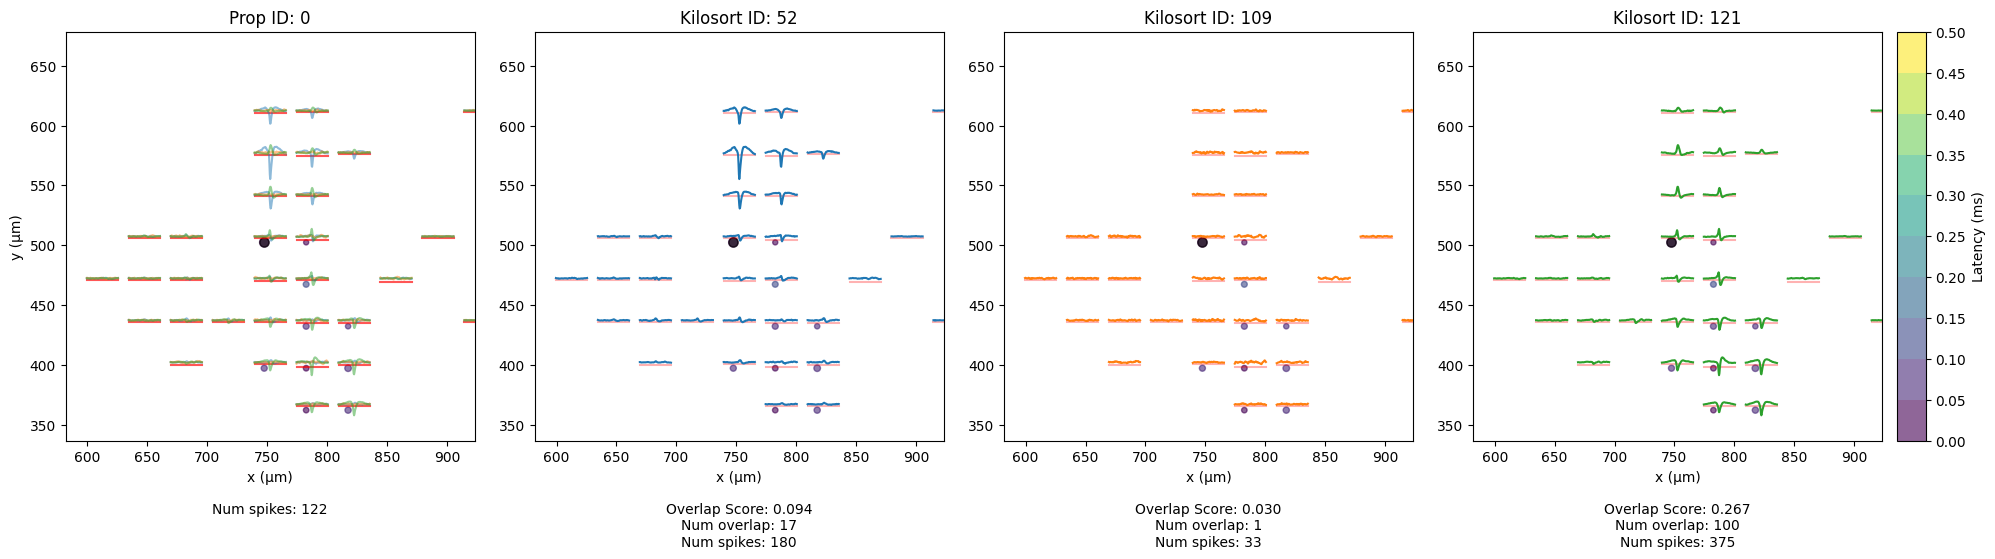

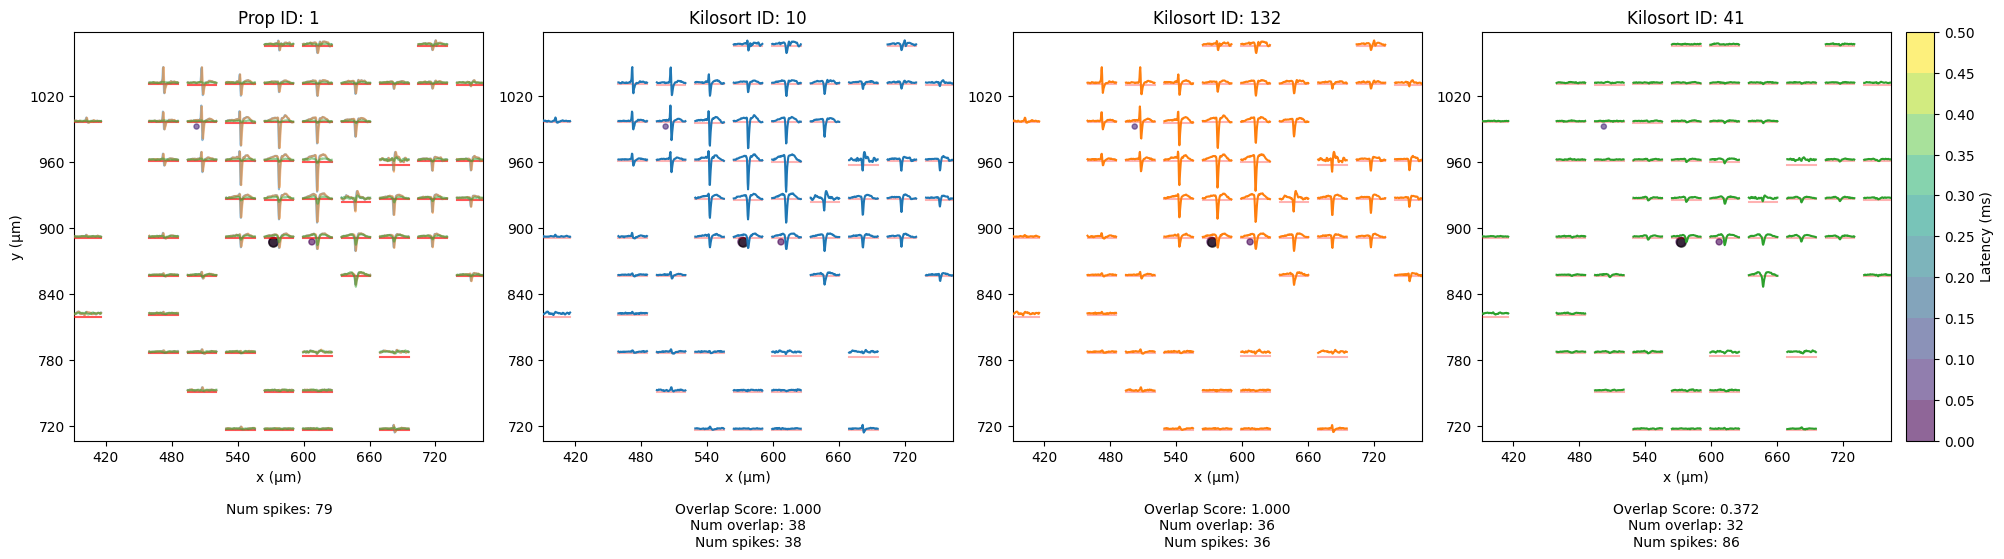

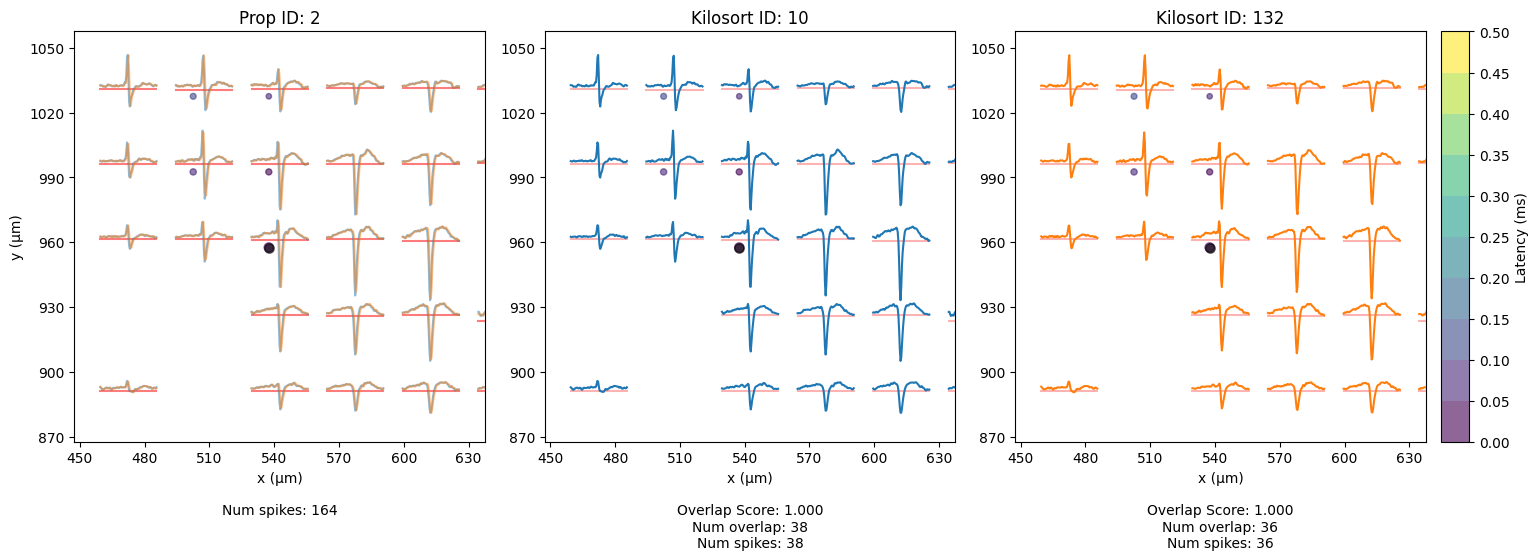

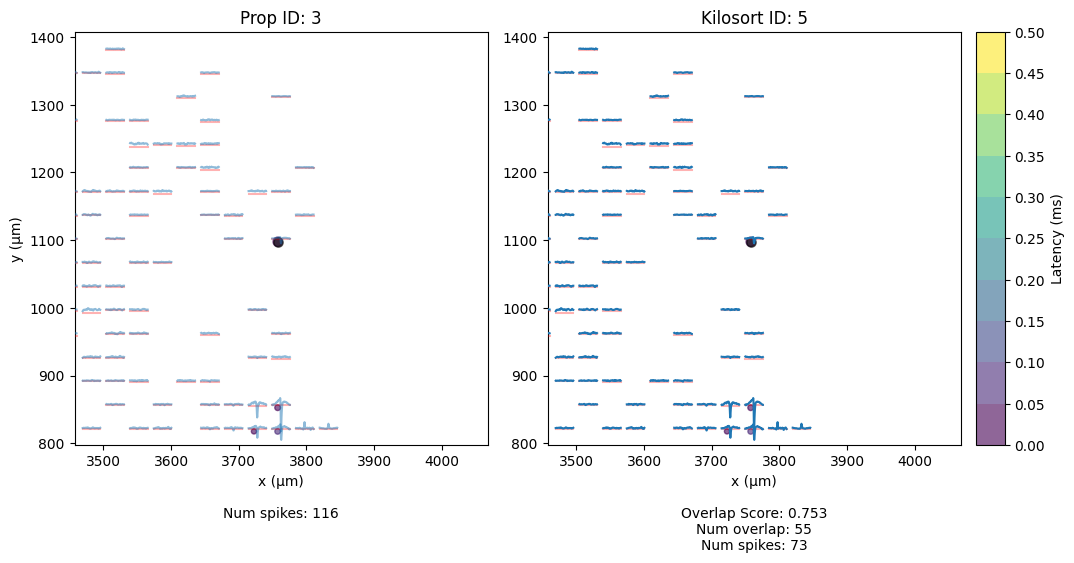

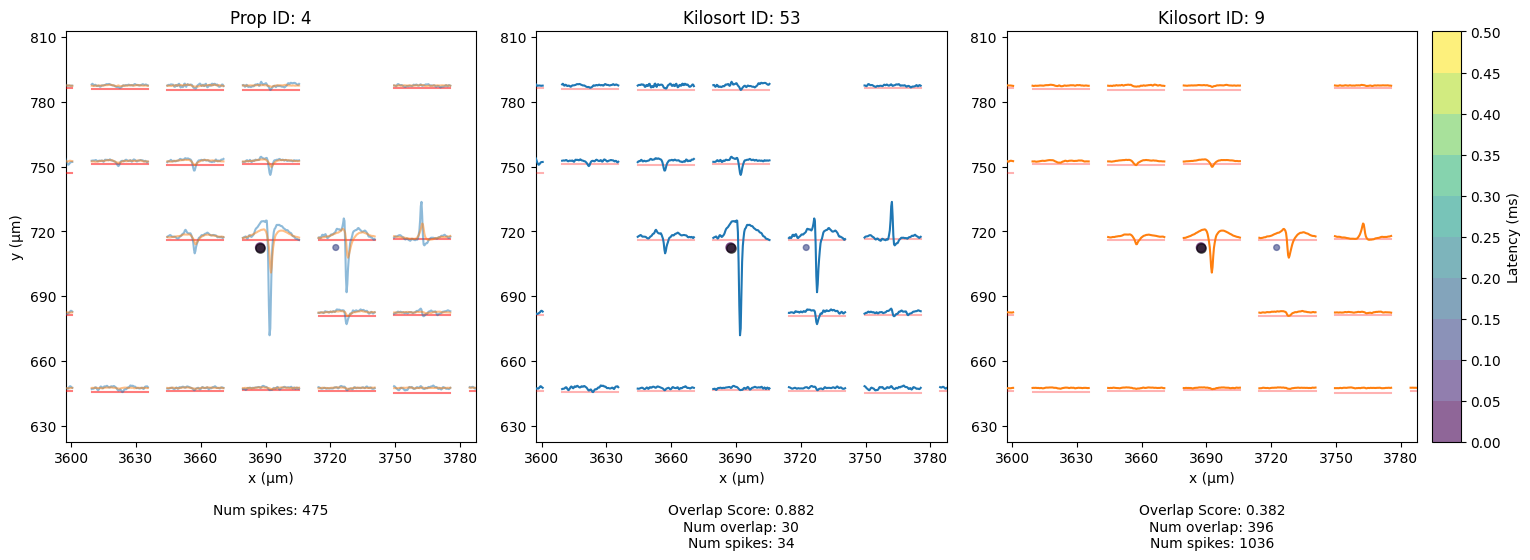

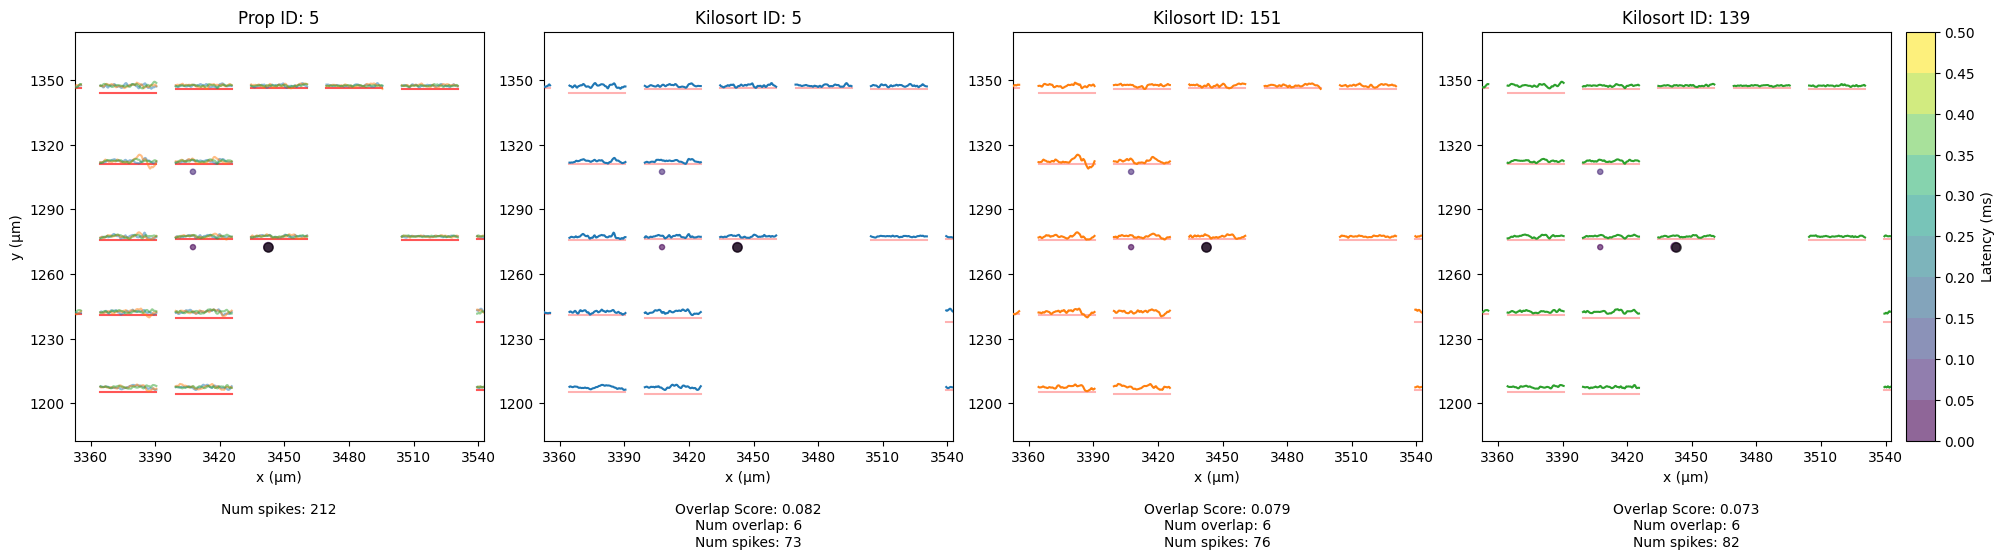

In [354]:
for prop_idx in range(0, len(PROP_SIGNAL)):
    under_merge = UnderMerge(prop_idx, match_thresh=0.3)
    under_merge.plot_footprints()

    if prop_idx == 5:
        break

In [355]:
ROOT_PATH = Path("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2953/230101_133514_582221/log/windows_200_120/prop_signal/waveform_footprints/undermerge/ks")
##
ROOT_PATH.mkdir(parents=True, exist_ok=True)

for prop_idx in tqdm(range(0, len(PROP_SIGNAL))):
    under_merge = UnderMerge(prop_idx, match_thresh=0.3)
    under_merge.plot_footprints(save=True)

100%|██████████| 90/90 [00:58<00:00,  1.53it/s]


## Plot rasters

In [ ]:
prop_idx = 42# 35
under_merge = UnderMerge(prop_idx)
under_merge.plot_raster_search(0, rec_duration_ms, window_duration=1.5*3, min_count=5, search_ind=None)

In [ ]:
prop_idx = 50# 35
under_merge = UnderMerge(prop_idx)
under_merge.plot_raster_search(0, rec_duration_ms, window_duration=1.5*3, min_count=5, search_ind=None)

In [ ]:
prop_idx = 71# 35
under_merge = UnderMerge(prop_idx)
under_merge.plot_raster_search(0, rec_duration_ms, window_duration=5, min_count=5, search_ind=None)

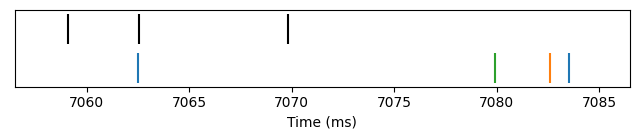

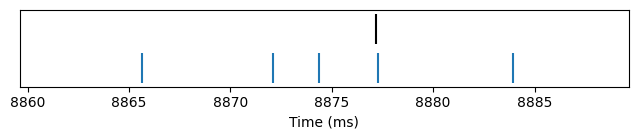

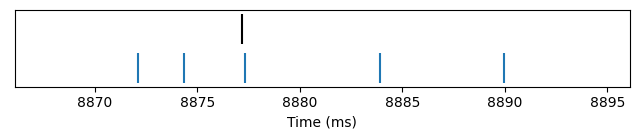

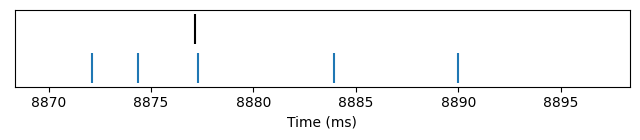

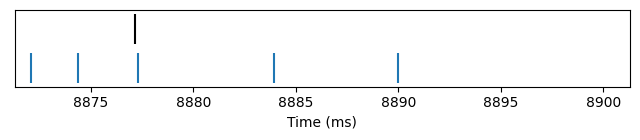

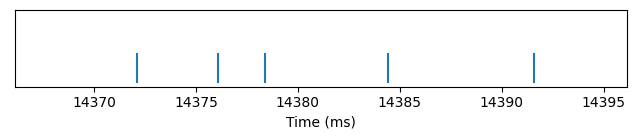

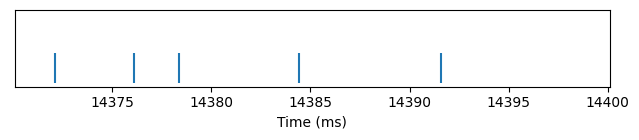

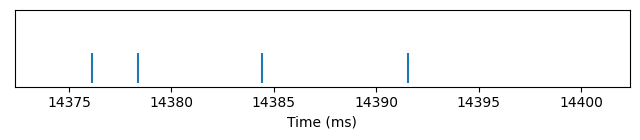

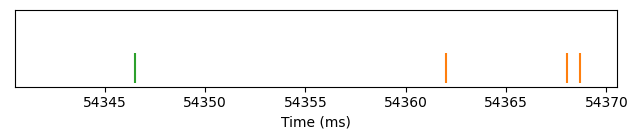

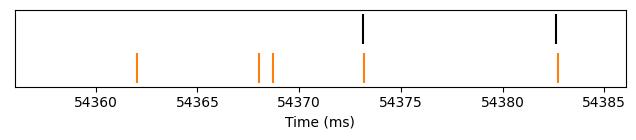

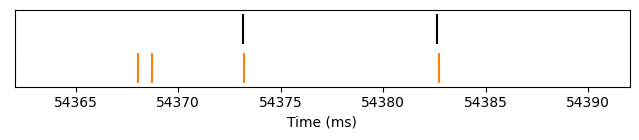

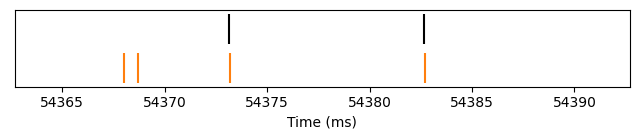

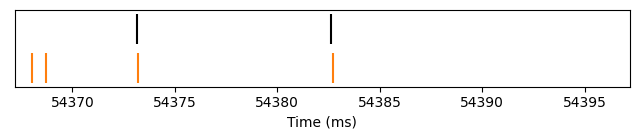

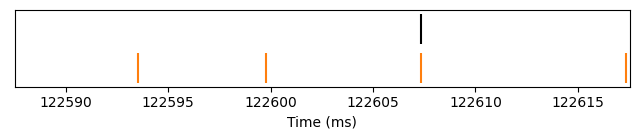

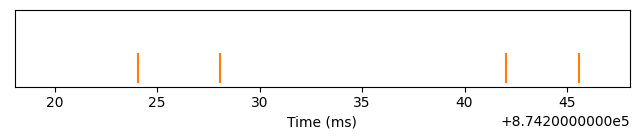

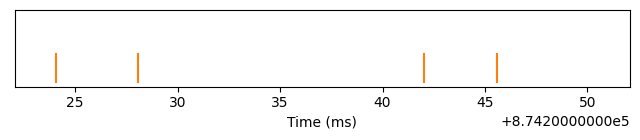

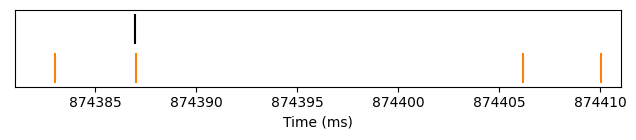

In [570]:
prop_idx = 94# 35
under_merge = UnderMerge(prop_idx)
under_merge.plot_raster_search(0, rec_duration_ms, window_duration=30, min_count=4, search_ind=None)

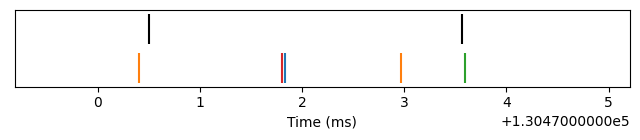

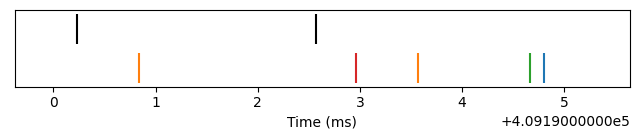

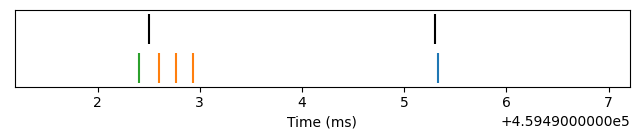

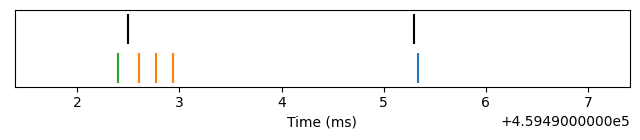

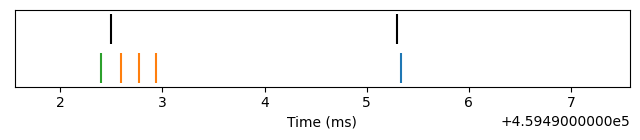

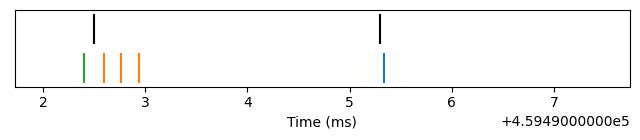

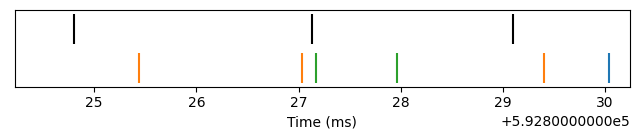

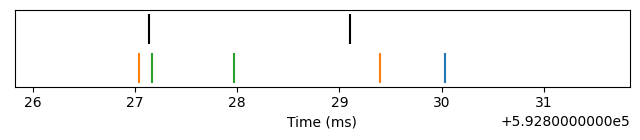

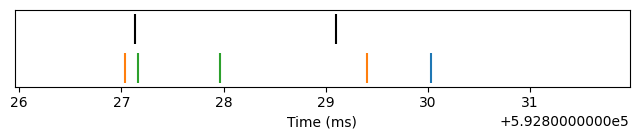

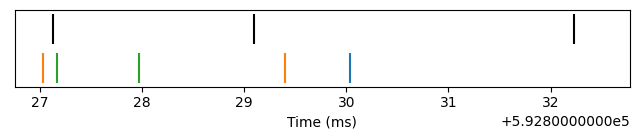

In [574]:
prop_idx = 119# 35
under_merge = UnderMerge(prop_idx)
under_merge.plot_raster_search(0, rec_duration_ms, window_duration=6, min_count=5, search_ind=None)

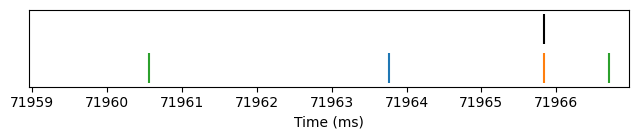

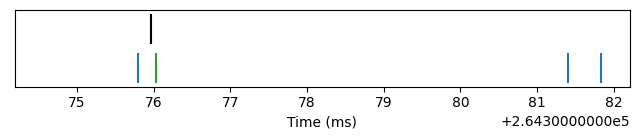

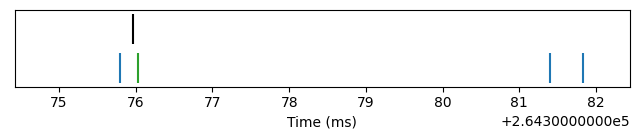

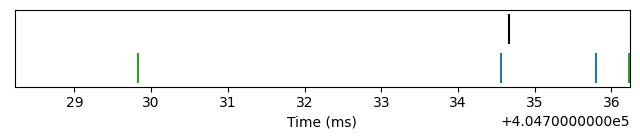

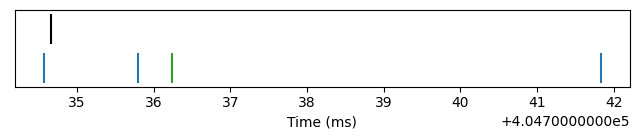

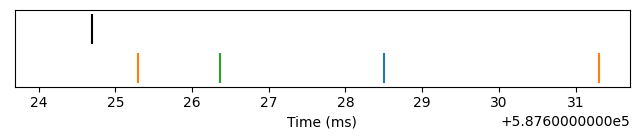

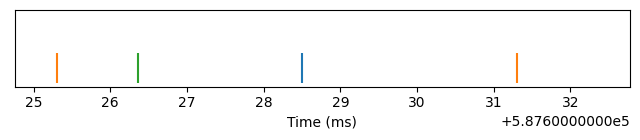

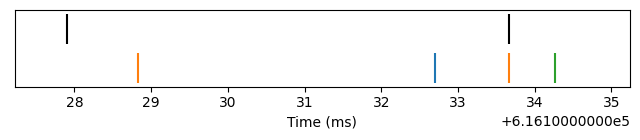

In [577]:
prop_idx = 125# 35
under_merge = UnderMerge(prop_idx)
under_merge.plot_raster_search(0, rec_duration_ms, window_duration=8, min_count=4, search_ind=None)

In [ ]:
for prop_idx in range(len(prop_signal)):
    print(prop_idx)
    under_merge = UnderMerge(prop_idx)
    under_merge.plot_raster_search(0, rec_duration_ms,
                               window_duration=1, min_count=9)

In [443]:
prop_signal[prop_idx].spike_train

[231.43333333333334,
 335.3666666666667,
 442.3,
 528.4333333333333,
 722.7333333333333,
 756.6,
 1083.3,
 1085.7333333333333,
 1811.3666666666666,
 1959.3333333333333,
 1972.6666666666667,
 2102.1,
 2199.733333333333,
 2214.4,
 2229.266666666667,
 2258.2,
 2289.0,
 2293.3,
 2333.3333333333335,
 2462.4666666666667,
 2471.9333333333334,
 2477.3333333333335,
 2512.5,
 2766.5333333333333,
 4298.433333333333,
 4300.766666666666,
 4515.133333333333,
 4585.133333333333,
 4590.433333333333,
 4777.3,
 4783.066666666667,
 5005.933333333333,
 5011.666666666667,
 5016.633333333333,
 5021.333333333333,
 5023.233333333334,
 5029.2,
 5032.033333333334,
 5181.333333333333,
 5219.1,
 5221.433333333333,
 5306.366666666667,
 5337.466666666666,
 5489.5,
 6057.066666666667,
 6165.166666666667,
 6374.233333333334,
 6407.133333333333,
 6420.3,
 6453.133333333333,
 6464.166666666667,
 6469.166666666667,
 6494.266666666666,
 6505.833333333333,
 6547.266666666666,
 6736.566666666667,
 6757.733333333334,
 6761.

In [438]:
# Create the plots
# def job_plot(prop_idx):
#     UnderMerge(prop_idx).plot_template(save=True)
#
# with Pool(processes=22) as pool:
#     tasks = range(len(prop_signal))
#     for _ in tqdm(pool.imap(job_plot, tasks), total=len(tasks)):
#         pass

100%|██████████| 129/129 [00:16<00:00,  8.03it/s]


In [ ]:
# MATCH_THRESH = 0.5
# ##
# under_merges_all = []
# # for prop_idx in range(len(prop_signal)):
# prop_idx = 35
# ks_scores = comparison.agreement_scores[prop_idx, :]
# ks_ind = np.flatnonzero(ks_scores >= MATCH_THRESH)
# ks_scores = ks_scores[ks_ind]
# under_merge = UnderMerge(ks_ind, ks_scores, prop_signal[prop_idx])
# under_merge.plot()